
# Factchecking with LangGraph

In [ ]:
!pip install langchain_community langchain_openai langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found exis

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [ ]:
#adding API KEYS for OpenAI and TAVILY
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [ ]:
tool = TavilySearchResults(max_results=3) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [ ]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [ ]:
prompt = """You are an expereinced FactChecker. Claim: "Mountain Rwenzori is the tallest Mountain in the World" \
Task: Fact-check this claim using current, reliable sources from the web. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
Instructions: 1. "Use a search tool to access up-to-date information" 2. "If the claim is verified by relaible sources, return: TRUE". \
3. "If the claim is contradicted by reliable sources, retur: FALSE" 4. If no conclusive information is found, return: PLAUSIBLE". \
Your Response should always be:
[TRUE / FALSE / PLAUSIBLE]
Short explanation with source(s).
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

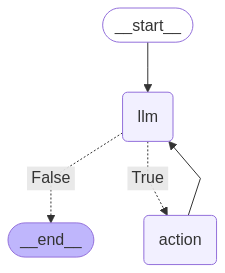

In [ ]:
from IPython.display import Image, display

try:
    display(Image(abot.graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
messages = [HumanMessage(content="President Museveni is the President of Kenya")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'President Museveni President of Kenya'}, 'id': 'call_qzWues6IjAB4Xa44jzhnlKrU', 'type': 'tool_call'}
Back to the model!


In [ ]:
result['messages'][-1].content

'FALSE\nPresident Museveni is not the President of Kenya. He is the President of Uganda. President Museveni recently arrived in Kenya for a state visit at the invitation of President William Ruto according to [nrm.ug](https://www.nrm.ug/blog/president-museveni-arrives-kenya-strengthen-bilateral-relations).'

In [ ]:
messages = [HumanMessage(content="Uganda's literacy rate is higher than Kenya's and is at 90%")]
result = abot.graph.invoke({"messages": messages})
result['messages'][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Uganda literacy rate 2021'}, 'id': 'call_WJ7t2gbI8sjbVYOd389UYVep', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kenya literacy rate 2021'}, 'id': 'call_yErVyu4mDPEx9gIfVROQ7JuW', 'type': 'tool_call'}
Back to the model!


"Based on the search results, as of 2021:\n- Uganda's adult literacy rate is around 80.59%, not 90%. ([source](https://countryeconomy.com/demography/literacy-rate/uganda))\n- Kenya's adult literacy rate is around 98.13%, which is higher than Uganda's. ([source](https://countryeconomy.com/demography/literacy-rate?year=2021))\n\nTherefore, the claim that Uganda's literacy rate is higher than Kenya's at 90% is **FALSE**."